In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
df = pd.read_excel('../../../OldDatasets/ML_data.xlsx')
#df.head()

removing blank columns

In [4]:
df.dropna(axis=1, inplace=True)
#df.head()

### How much data on each type of semiconductor exists?
- ~3/5 II-VI semiconductors and ~1/5 each III-V and IV-IV semicondutors.

In [8]:
counter(df, 'Type')

Total entries:  853


,Type,percent
II-VI,506,59.32
IV-IV,192,22.51
III-V,155,18.17


In [9]:
df.shape

(853, 52)

In [10]:
df.columns

Index(['Type', 'AB', 'Site', 'Impurity', '∆H (A-rich)', '∆H (B-rich)',
       '(+2/+1)', '(+1/0)', '(0/-1)', '(-1/-2)', 'Z_A', 'Z_B', 'PBE_delta_H',
       'PBE_latt_const', 'PBE_gap', 'Eps_elec', 'Eps_ion', 'CM1', 'CM2', 'CM3',
       'CM4', 'CM5', 'CM6', 'CM7', 'CM8', 'Ion_rad', 'BP', 'MP', 'Density',
       'At_wt', 'ICSD_vol', 'Cov_rad', 'Ion_Energy', 'At_rad_1', 'Elec_Aff',
       'At_rad_2', 'At_vol', 'Mend_num', 'Ion_pot_1', 'Ion_pot_2',
       'Thermal_expn', 'Sp_heat_cap', 'Therm_cond', 'Elec_cond', 'Heat_fusion',
       'Heat_vap', 'Electronegativity', 'At_num', 'Period', 'Group', 'Valence',
       'Ox_state'],
      dtype='object')

### Descriptors

In [11]:
descriptors = df.columns[10:]
descriptors

Index(['Z_A', 'Z_B', 'PBE_delta_H', 'PBE_latt_const', 'PBE_gap', 'Eps_elec',
       'Eps_ion', 'CM1', 'CM2', 'CM3', 'CM4', 'CM5', 'CM6', 'CM7', 'CM8',
       'Ion_rad', 'BP', 'MP', 'Density', 'At_wt', 'ICSD_vol', 'Cov_rad',
       'Ion_Energy', 'At_rad_1', 'Elec_Aff', 'At_rad_2', 'At_vol', 'Mend_num',
       'Ion_pot_1', 'Ion_pot_2', 'Thermal_expn', 'Sp_heat_cap', 'Therm_cond',
       'Elec_cond', 'Heat_fusion', 'Heat_vap', 'Electronegativity', 'At_num',
       'Period', 'Group', 'Valence', 'Ox_state'],
      dtype='object')

#### Different descriptor classes

properties of compound AB

In [12]:
prop_AB = descriptors[:7]
prop_AB

Index(['Z_A', 'Z_B', 'PBE_delta_H', 'PBE_latt_const', 'PBE_gap', 'Eps_elec',
       'Eps_ion'],
      dtype='object')

coulombic matrix calculations

In [13]:
coulomb_mat = descriptors[7:15]
coulomb_mat

Index(['CM1', 'CM2', 'CM3', 'CM4', 'CM5', 'CM6', 'CM7', 'CM8'], dtype='object')

properties of impurity atom

In [14]:
prop_impurity = descriptors[15:]
prop_impurity

Index(['Ion_rad', 'BP', 'MP', 'Density', 'At_wt', 'ICSD_vol', 'Cov_rad',
       'Ion_Energy', 'At_rad_1', 'Elec_Aff', 'At_rad_2', 'At_vol', 'Mend_num',
       'Ion_pot_1', 'Ion_pot_2', 'Thermal_expn', 'Sp_heat_cap', 'Therm_cond',
       'Elec_cond', 'Heat_fusion', 'Heat_vap', 'Electronegativity', 'At_num',
       'Period', 'Group', 'Valence', 'Ox_state'],
      dtype='object')

### Targets
- formation energy (2)
- transition energy level (4)

In [15]:
output = df.columns[4:10]
output

Index(['∆H (A-rich)', '∆H (B-rich)', '(+2/+1)', '(+1/0)', '(0/-1)', '(-1/-2)'], dtype='object')

### Splitting the data into a test and train set. 
- the ratio of types is maintained in the test and train data sets (~3/5 II-VI semiconductors and ~1/5 each III-V and IV-IV semiconductors).

In [16]:
train,test = train_test_split(df,test_size=0.22, random_state=130)

In [17]:
counter(test, 'Type')

Total entries:  188


,Type,percent
II-VI,111,59.04
IV-IV,41,21.81
III-V,36,19.15


In [18]:
counter(train, 'Type')

Total entries:  665


,Type,percent
II-VI,395,59.40
IV-IV,151,22.71
III-V,119,17.89


#### Visulaizing the spread of the descriptor data, i.e. if it is normally distributed, or no distribution whatsoever.

In [19]:
df_descrip = df.copy()
df_descrip.drop(df_descrip.columns[0:10], axis=1, inplace=True)
#df_descrip.head()

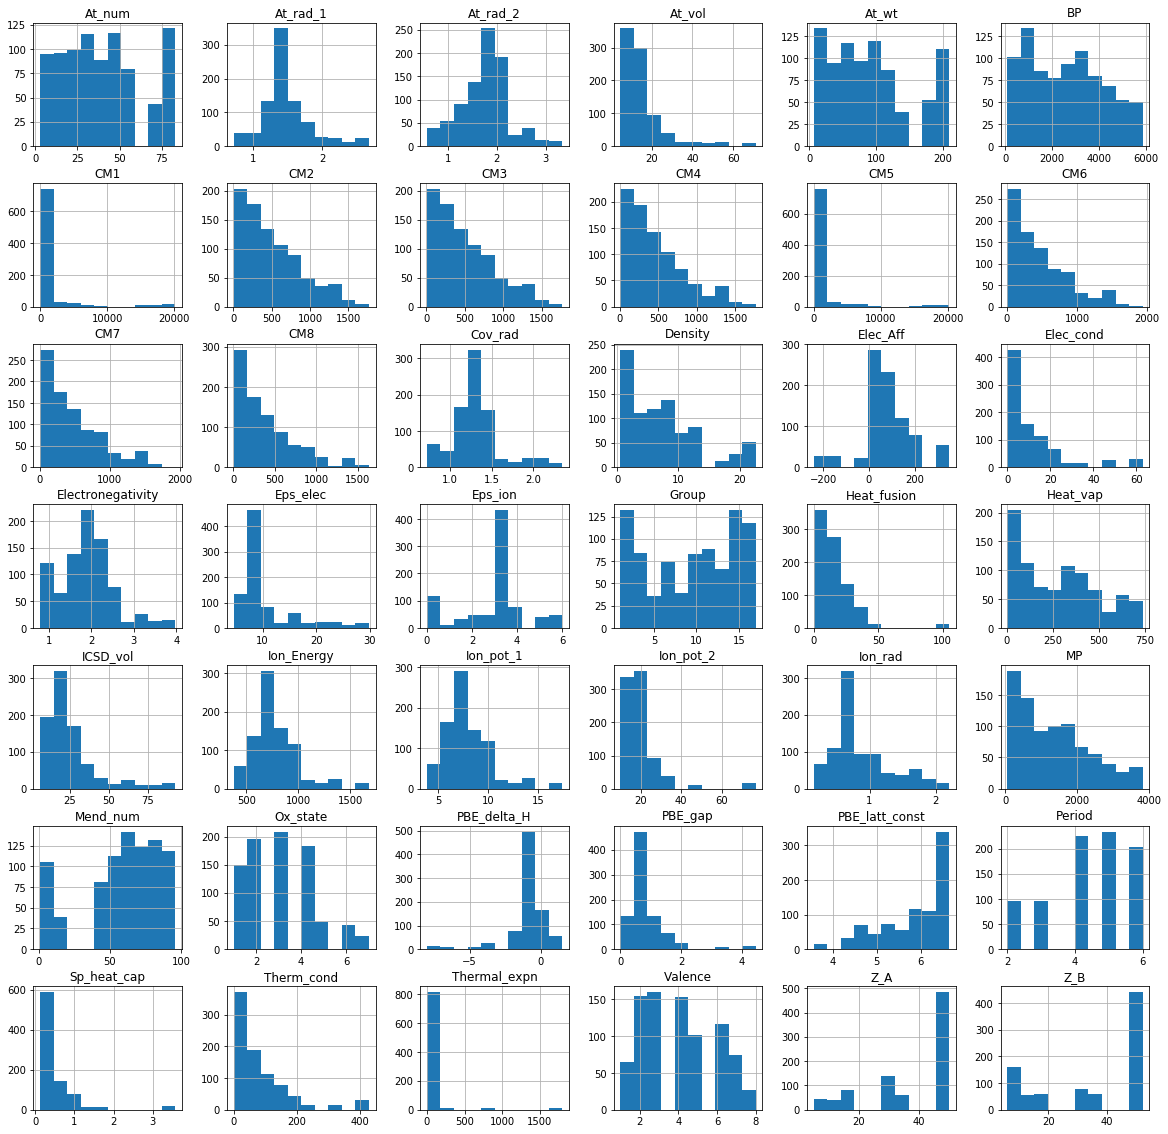

In [20]:
df_descrip.hist(figsize=(20,20))
plt.show()

-----------------
---------------

# New dataframes
- ``df``: original dataframe, nothing changed
- ``df_copy``: Low correlation dataframe (dropping descriptors columns that have very low correlation with predicted values)
- ``df_newcopy`` : Low correlation dataframe AND removing outliers (dropping columns that have formation energies above 10 eV)
- ``df_nooutliers`` : original data frame AND removing outliers (dropping columns that have formation energies above 10 eV)
- ``df_onehot`` : original data frame with the categorical numerical values one-hot encoded

In [21]:
df_copy = df.copy()

#### ``df_copy``: Dropping columns that have very low correlation with predicted values.
- valence
- period
- group
- oxidation state
- atomic number
- atomic weight
- mend num (??)

In [22]:
df_copy.drop(['Valence', 'Period', 'Group', 'Ox_state', 'At_num', 'At_wt', 'Mend_num'], axis=1, inplace=True)
#df_copy

In [23]:
counter(df_copy, 'Type')

Total entries:  853


,Type,percent
II-VI,506,59.32
IV-IV,192,22.51
III-V,155,18.17


#### ``df_newcopy`` : Low correlation dataframe AND removing outliers
dropping columns that have formation energies above 10 eV

In [24]:
df_newcopy = df_copy[(df_copy['∆H (A-rich)'] <= 10) & (df_copy['∆H (B-rich)'] <= 10)]
#df_newcopy

In [25]:
counter(df_newcopy, 'Type')

Total entries:  766


,Type,percent
II-VI,482,62.92
IV-IV,154,20.10
III-V,130,16.97


#### ``df_nooutliers`` : original data frame ONLY removing outliers 
dropping columns that have formation energies above 10 eV

In [26]:
df_nooutliers = df[(df['∆H (A-rich)'] <= 10) & (df['∆H (B-rich)'] <= 10)]
#df_nooutliers

In [27]:
counter(df_nooutliers, 'Type')

Total entries:  766


,Type,percent
II-VI,482,62.92
IV-IV,154,20.10
III-V,130,16.97


#### ``df_onehot`` : original dataframe with numerical categorical descriptors one-hot encoded
- descriptors that are numerically categorical are: 'Z_A', 'Z_B', 'Mend_num', 'At_num', 'Period', 'Group', 'Valence', 'Ox_state'

In [28]:
cat_descrip = list(df.select_dtypes(include='int').columns)
cat_descrip

['Z_A', 'Z_B', 'Mend_num', 'At_num', 'Period', 'Group', 'Valence', 'Ox_state']

In [29]:
df_onehot = pd.get_dummies(df, columns=cat_descrip)
print(df_onehot.shape)
#df_onehot.head()

(853, 229)


# Random Forest Modeling
- different descriptors
- removing outliers
- one-hot encoding

#### Function to plot and compute RMSE of model

In [36]:
def RFR(df, d_start=10, o_start=4, o_end=10,
                    test_size=0.22, num_trees=500, max_feat='auto',
                    max_depth=5, min_samp_leaf=2, min_samples_split=2,
                    rs = 130, rs_split = 130, fig_w=12, fig_h=8):
    '''
    o_start: int. column index of target value. (4 is the beginning)
    o_end: int. column index of target value. (10 is the end)
    '''
    descriptors = df.columns[d_start:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_estimators = num_trees, max_features=max_feat,
                        max_depth = max_depth, min_samples_leaf= min_samp_leaf,
                        min_samples_split= min_samples_split, n_jobs=2,
                        random_state=rs)
    
    print('Model Parameters:', clf.get_params)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    fig, axs = plt.subplots(1,6, figsize=(30,4))
    fig.subplots_adjust(wspace=0.2)
    
    for i, o in enumerate(output):
        clf.fit(train[descriptors], train[o])

        trainpred = clf.predict(train[descriptors])
        testpred = clf.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

        #parity plot 
        axs[i].scatter(train[o],trainpred, alpha = 0.5, label='train')
        axs[i].scatter(test[o],testpred, color='r', alpha = 0.5, label='test')
        axs[i].set_xlabel('train/test data')
        axs[i].set_ylabel('predicted train/test')
        axs[i].plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],alpha=0.7,color='black')
        axs[i].set_title(o)
        axs[i].legend()
        #plt.show()

        descrip_importance = list(zip(train[descriptors], clf.feature_importances_))
        descr_df = pd.DataFrame(descrip_importance, columns =['predictor', o])
        frames_list.append(descr_df)
        #print(descr_df)
    
    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    result = pd.concat(frames_list, axis=1)
    result.drop(['predictor'], axis=1, inplace=True)
    result.insert(0, 'predictor', descriptors)
    
    result.set_index('predictor', inplace=True)
    
    plt.figure(figsize=(12,8))
    plt.title('Descriptor Importance in RFR model')
    sns.heatmap(result, annot=True, cmap='Oranges')
    plt.show()
    
    return rmse_df

### No tuning of descriptors (``df``)

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


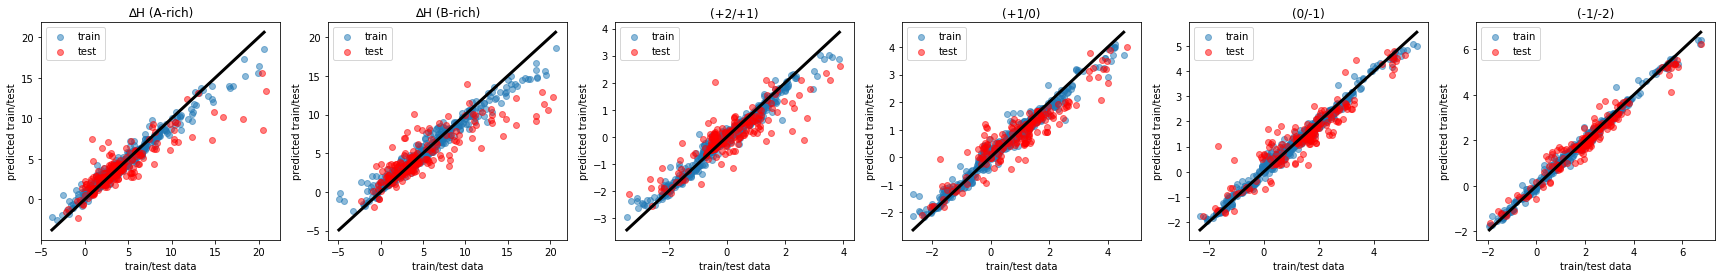

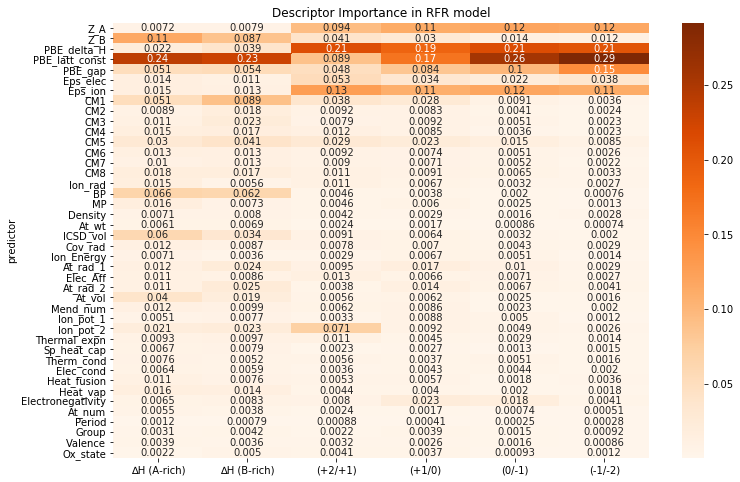

,output,train rmse,test rmse
0,∆H (A-rich),0.683523,2.018260
1,∆H (B-rich),0.854002,2.451177
2,(+2/+1),0.214799,0.608139
3,(+1/0),0.219321,0.522942
4,(0/-1),0.162004,0.507439
5,(-1/-2),0.135858,0.328704


In [32]:
RFR(df)

### One-hot encoding of numerical descriptors - ``df_onehot``
**This makes very little difference in the performance of the model**

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


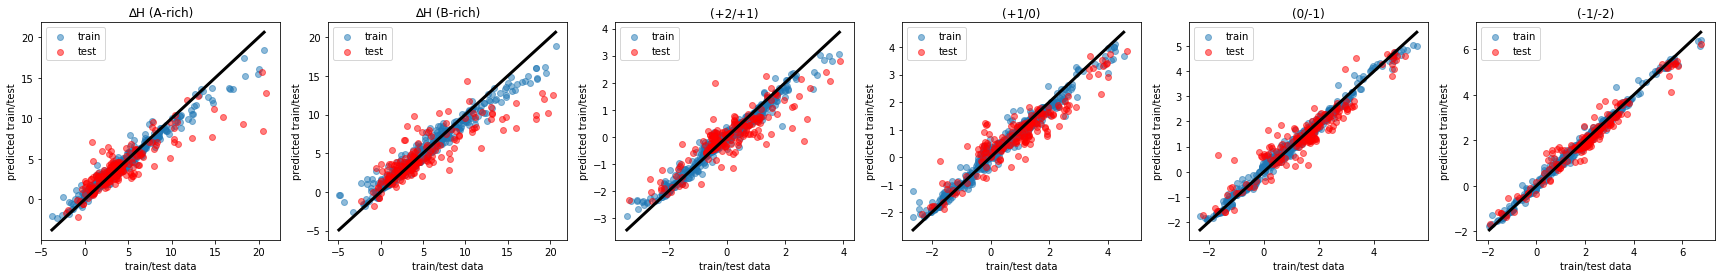

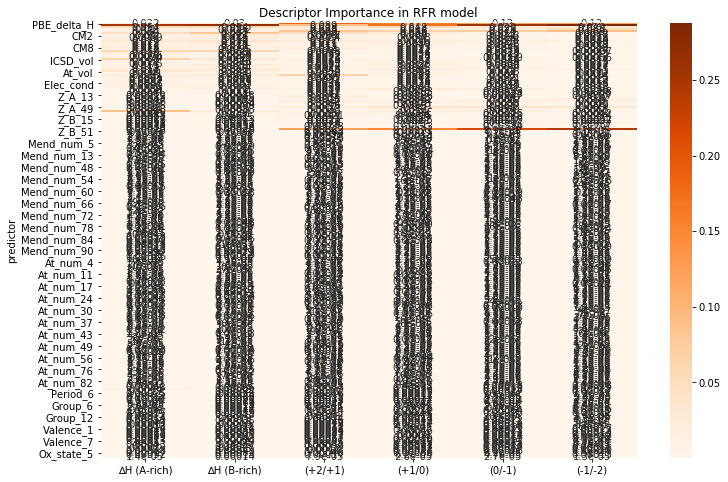

,output,train rmse,test rmse
0,∆H (A-rich),0.691133,2.029953
1,∆H (B-rich),0.876976,2.423567
2,(+2/+1),0.222138,0.613194
3,(+1/0),0.216731,0.522456
4,(0/-1),0.158365,0.474847
5,(-1/-2),0.132380,0.326965


In [33]:
RFR(df_onehot)

### Removed entries with formation energy greater than 10 eV - ``df_nooutliers``:
**This made a large difference in the performance of the model to predict the formation enthalpies**

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


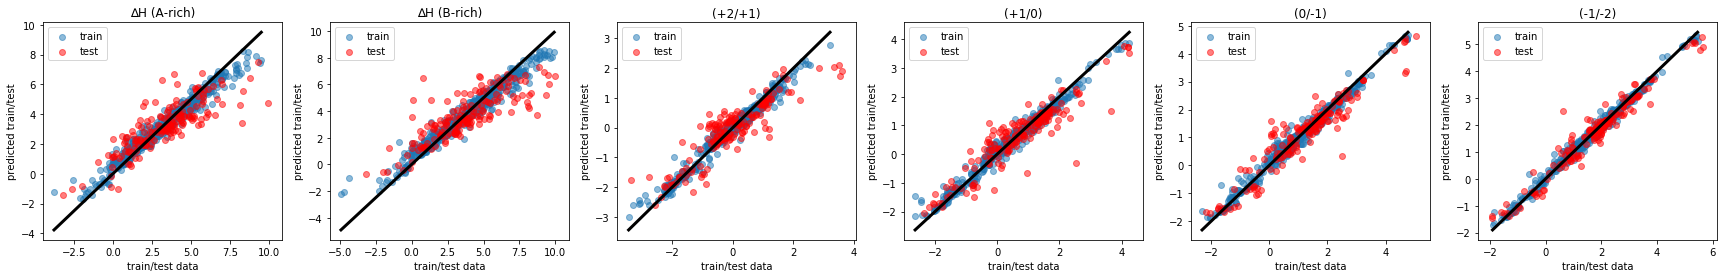

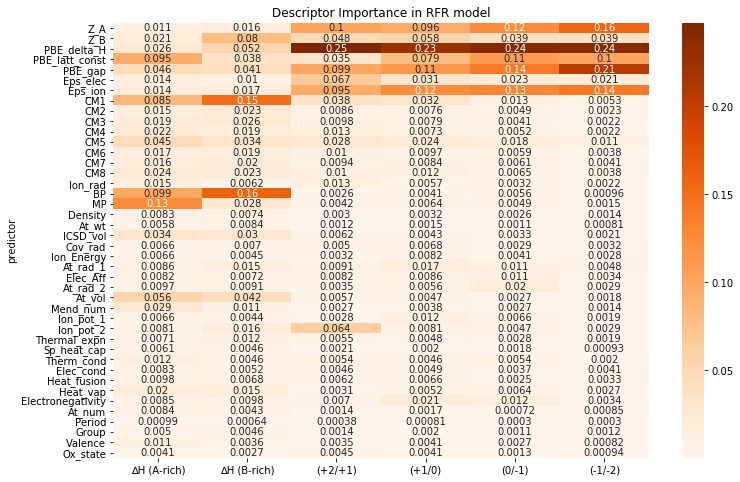

,output,train rmse,test rmse
0,∆H (A-rich),0.482355,1.259348
1,∆H (B-rich),0.567460,1.519628
2,(+2/+1),0.179011,0.533859
3,(+1/0),0.188701,0.513070
4,(0/-1),0.169284,0.461905
5,(-1/-2),0.129970,0.323699


In [34]:
RFR(df_nooutliers)

Model Parameters: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


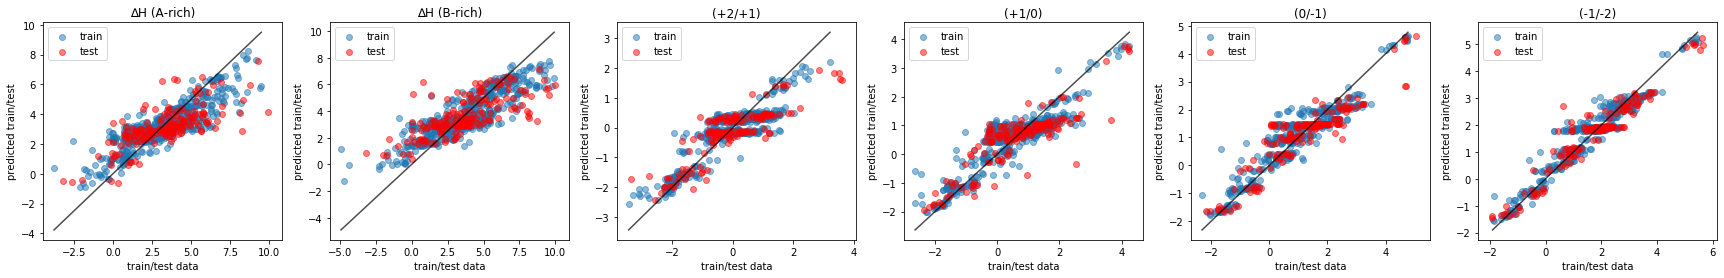

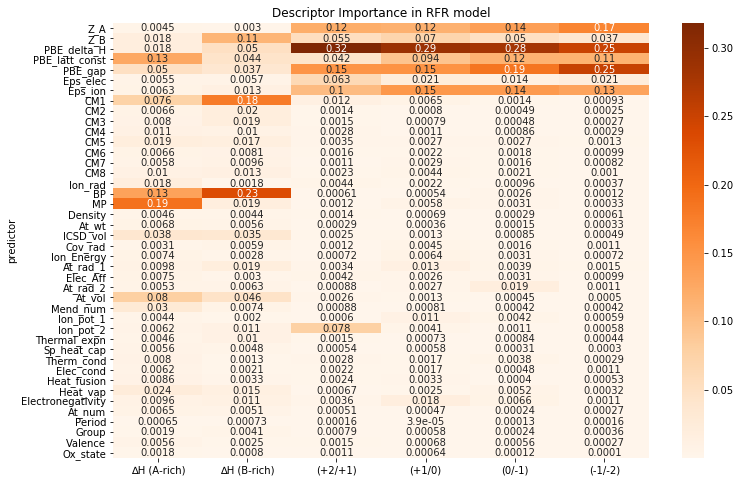

,output,train rmse,test rmse
0,∆H (A-rich),1.154784,1.533201
1,∆H (B-rich),1.275239,1.789717
2,(+2/+1),0.499333,0.627582
3,(+1/0),0.530052,0.649744
4,(0/-1),0.465602,0.566927
5,(-1/-2),0.349498,0.409422


In [37]:
RFR(df_nooutliers)

### Removed descriptors with the least amount of correlation- ``df_copy``. Determined by:
- the historgram plots that showed no correlation in any direction (ie no trend)
- had an "importance" of < 0.01

**This made very little difference in the performance of the model**

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


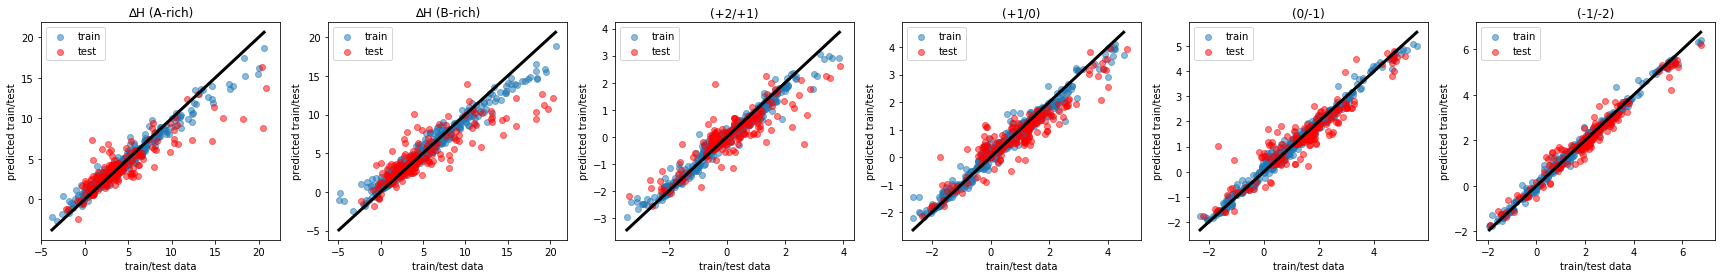

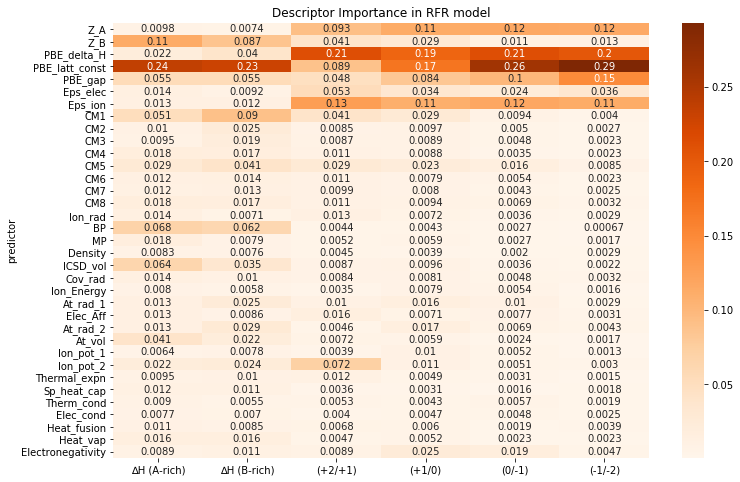

,output,train rmse,test rmse
0,∆H (A-rich),0.685437,2.014411
1,∆H (B-rich),0.840143,2.435491
2,(+2/+1),0.214130,0.602130
3,(+1/0),0.219157,0.525350
4,(0/-1),0.162507,0.510461
5,(-1/-2),0.136154,0.331837


In [35]:
RFR(df_copy)

### Removed entries from ``df_copy`` that had formation energy greater than 10 eV - ``df_newcopy``:
**This made a large difference in the performance of the model, similar to just removing outliers from og dataframe**

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


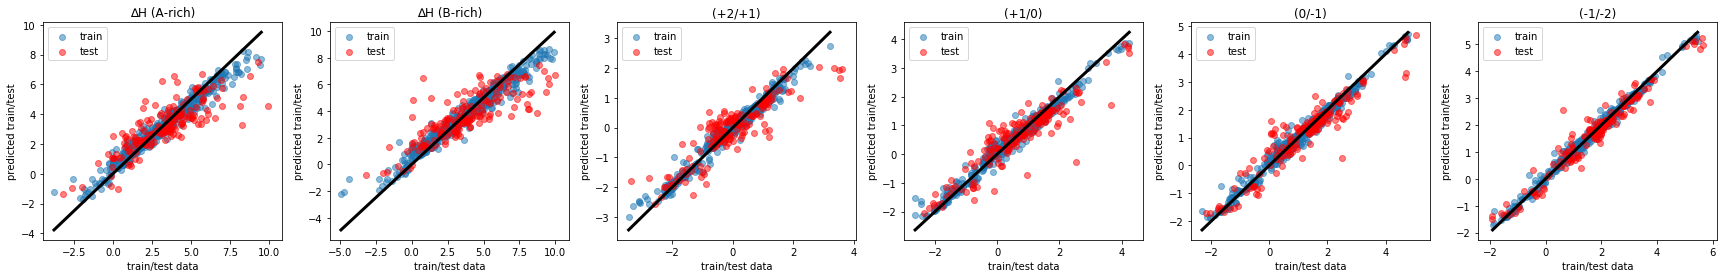

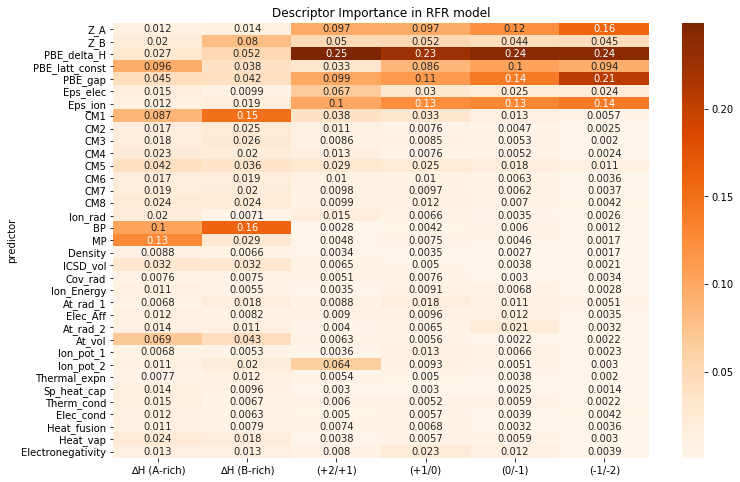

,output,train rmse,test rmse
0,∆H (A-rich),0.484411,1.285502
1,∆H (B-rich),0.570935,1.522478
2,(+2/+1),0.179928,0.542089
3,(+1/0),0.189089,0.515376
4,(0/-1),0.166528,0.464314
5,(-1/-2),0.130922,0.323178


In [36]:
RFR(df_newcopy)

---------
------

## Evaluating model by how it predicts for each type of semiconductor

In [37]:
def RFR_type(df, o_start=4, o_end=10):
    
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_jobs=2, random_state=130)
    
    train_26 = train[train['Type']=='II-VI']
    train_35 = train[train['Type']=='III-V']
    train_44 =  train[train['Type']=='IV-IV']

    test_26 = test[test['Type']=='II-VI']
    test_35 = test[test['Type']=='III-V']
    test_44 = test[test['Type']=='IV-IV']
    
    traintest_list = [(train_26, test_26),(train_35, test_35),(train_44, test_44)]
    
    tt_dict = {}
    
    for tt in traintest_list:
        
        key = str(tt[0].Type.unique())
        
        train_rmse_list = [] 
        test_rmse_list = []
        
        for o in output:
            clf.fit(train[descriptors], train[o])

            trainpred = clf.predict(tt[0][descriptors])
            testpred = clf.predict(tt[1][descriptors])

            train_rmse = mean_squared_error(tt[0][o],trainpred, squared=False)
            test_rmse = mean_squared_error(tt[1][o],testpred, squared=False)

            
            train_rmse_list.append(train_rmse)
            test_rmse_list.append(test_rmse)
        
        #print('train', train_rmse_list)
        #print('test', test_rmse_list)
            
        d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}

        rmse_df = pd.DataFrame(data=d)
        
        tt_dict[key] = (rmse_df)
    
    fig, axs = plt.subplots(1,6, figsize=(30,4))
    fig.subplots_adjust(wspace=0.2)
        
    for i, o in enumerate(output):
        clf.fit(train[descriptors], train[o])
        
        alltrainpred = clf.predict(train[descriptors])
        #alltestpred = clf.predict(test[descriptors])
        
        groups = test.groupby('Type')
        
        axs[i].scatter(train[o],alltrainpred, label='train', alpha=0.5, color='gray')
        for (name, group) in groups:
            axs[i].scatter(group[o], clf.predict(group[descriptors]), alpha=0.7, label=name)
        axs[i].set_xlabel('train/test data')
        axs[i].set_ylabel('predicted train/test')
        axs[i].plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],lw=3,color='black')
        axs[i].set_title(o)
        axs[i].legend()
    
    return tt_dict

### Using ``df_nooutliers``

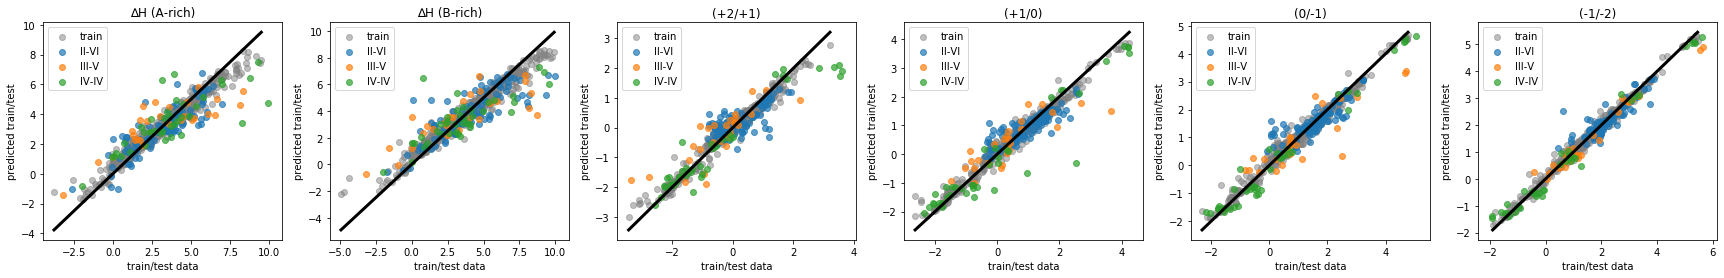

In [38]:
type_dict_dfnooutliers = RFR_type(df_nooutliers)

In [39]:
for key in type_dict_dfnooutliers.keys():
    type_df = type_dict_dfnooutliers[key]
    print(key)
    print(type_df)

['II-VI']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.389609   0.969060
1  ∆H (B-rich)    0.453989   1.352040
2      (+2/+1)    0.164972   0.462961
3       (+1/0)    0.164855   0.405235
4       (0/-1)    0.156690   0.411029
5      (-1/-2)    0.125387   0.333109
['III-V']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.687795   1.617362
1  ∆H (B-rich)    0.845043   1.948736
2      (+2/+1)    0.215866   0.640614
3       (+1/0)    0.243581   0.635599
4       (0/-1)    0.210179   0.715225
5      (-1/-2)    0.121028   0.325850
['IV-IV']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.532799   1.606666
1  ∆H (B-rich)    0.593988   1.596844
2      (+2/+1)    0.186884   0.620364
3       (+1/0)    0.205293   0.653705
4       (0/-1)    0.168191   0.352434
5      (-1/-2)    0.150864   0.295790


### Using ``df``

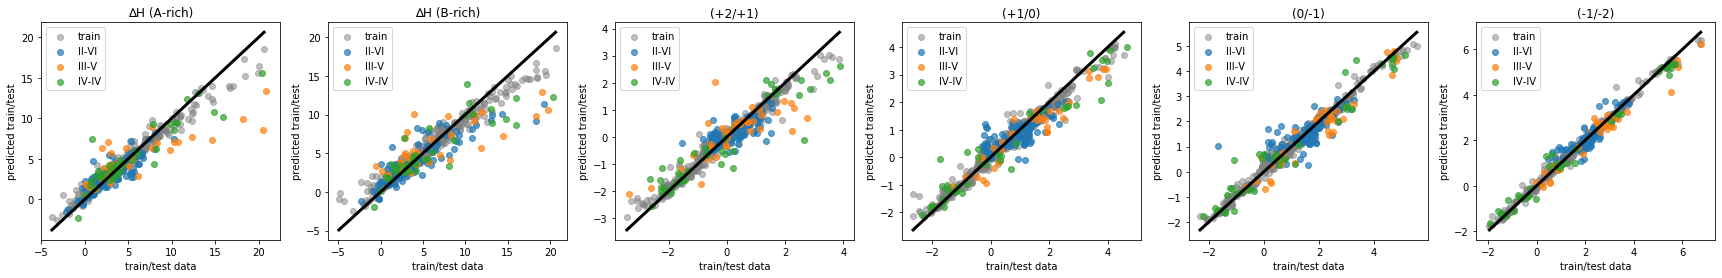

In [40]:
type_dict_df = RFR_type(df)

In [41]:
for key in type_dict_df.keys():
    type_df = type_dict_df[key]
    print(key)
    print(type_df)

['II-VI']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.439075   1.121649
1  ∆H (B-rich)    0.596918   1.917713
2      (+2/+1)    0.175582   0.441007
3       (+1/0)    0.173484   0.482641
4       (0/-1)    0.150954   0.511671
5      (-1/-2)    0.123975   0.305726
['III-V']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.879185   3.585558
1  ∆H (B-rich)    1.265501   3.522336
2      (+2/+1)    0.289136   0.828596
3       (+1/0)    0.305068   0.525889
4       (0/-1)    0.207630   0.473151
5      (-1/-2)    0.169137   0.397696
['IV-IV']
        output  train rmse  test rmse
0  ∆H (A-rich)    0.971641   1.995857
1  ∆H (B-rich)    1.008827   2.588397
2      (+2/+1)    0.238044   0.752621
3       (+1/0)    0.244471   0.616824
4       (0/-1)    0.148326   0.524729
5      (-1/-2)    0.136145   0.321730


-------
------

# Hyperparameter Tuning
- We are looking to optimize the parameters of the RFR to optimize the prediction.

### Random hyperparameter grid
Create a grid of the parameter space we want to explore. For RFR the most important parameters are:
- n_estimators: number of trees in the forest 
- max_depth: number of leaves in each decision tree
- min_sammples_split: minimum number of datapoints in a node before the node splits
- min_samples_leaf: minimum number of data points allowed in a leaf node

In [41]:
def RSCV_grid():

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(0, 50, num = 10)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    return random_grid

In [42]:
RSCV_grid()

{'n_estimators': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500],
 'max_depth': [0, 5, 11, 16, 22, 27, 33, 38, 44, 50, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

### Random Search Training
``RandomizedSearchCV``: randomized search on hyper parameters. Important arguements to set are n_iter and cv.
- n_iter: number of different combinations to try
- cv: number of folds to use for cross validation
In this example the model is going to ty 100 different combinations from the random grid, wih a 5-fold cross validation (ie 500 combinations).

Similar to other scikit-learn models:
- initiate the model (random search) with ``RandomizedSearchCV``
- fit the model

In [134]:
RESULTS = {}
def RFR_hyperparameter(df):
    descriptors = df.columns[10:]
    output = df.columns[4:10]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    
    clf = RandomForestRegressor()
    
    random_grid = RSCV_grid()
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    for o in output:
        clf_random = RESULTS.get(o)
        if clf_random is None:
            clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                               n_iter=100, cv=5, verbose=2, random_state=130, n_jobs=-1 )
            RESULTS[o] = clf_random

        clf_random.fit(train[descriptors], train[o])

        trainpred = clf_random.best_estimator_.predict(train[descriptors])
        testpred = clf_random.best_estimator_.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

        plt.figure(figsize=(4,4))
        plt.scatter(train[o],trainpred, label='train')
        plt.scatter(test[o],testpred,color='r', label='test')
        plt.xlabel('train/test data')
        plt.ylabel('predicted train/test')
        plt.plot([train[o].min(),train[o].max()],[trainpred.min(),trainpred.max()],lw=4,color='black')
        plt.title(o)
        plt.legend()
        plt.show()

        print("Train RMSE", train_rmse)
        print("Test RMSE", test_rmse)
        print('Best params:', clf_random.best_params_)

        descrip_importance = list(zip(train[descriptors], clf_random.best_estimator_.feature_importances_))
        descr_df = pd.DataFrame(descrip_importance, columns =['predictor', o])
        frames_list.append(descr_df)
    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    result = pd.concat(frames_list, axis=1)
    result.drop(['predictor'], axis=1, inplace=True)
    result.insert(0, 'predictor', descriptors)
    
    result.set_index('predictor', inplace=True)
    
    plt.figure(figsize=(12,8))
    sns.heatmap(result, annot=True, cmap='Oranges')
    plt.show()
    
    return rmse_df

### Hyper parameter tuning with ``df_nooutliers`` (all descriptors, outliers removed)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


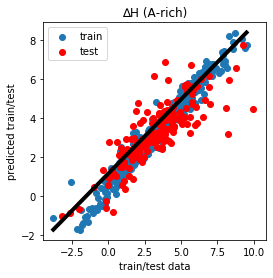

Train RMSE 0.48513786470488135
Test RMSE 1.2539367074490453
Best params: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 27}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


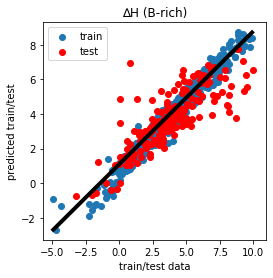

Train RMSE 0.5578263029041838
Test RMSE 1.532841965648391
Best params: {'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 44}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.2min finished


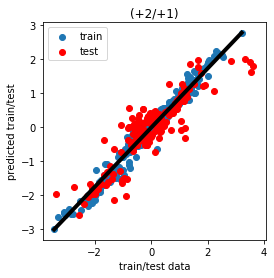

Train RMSE 0.1780444148254704
Test RMSE 0.5405831483022103
Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.3min finished


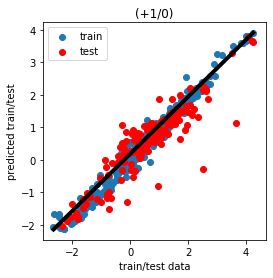

Train RMSE 0.18505213785195096
Test RMSE 0.527087516321255
Best params: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 27}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.4min finished


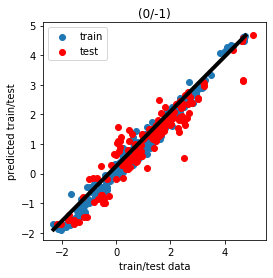

Train RMSE 0.16705517568373224
Test RMSE 0.45555253742648105
Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 27}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.1min finished


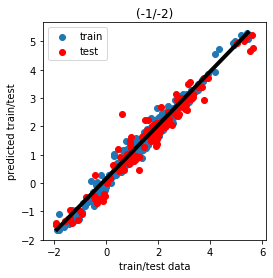

Train RMSE 0.15725891719642493
Test RMSE 0.32243453147652174
Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 22}


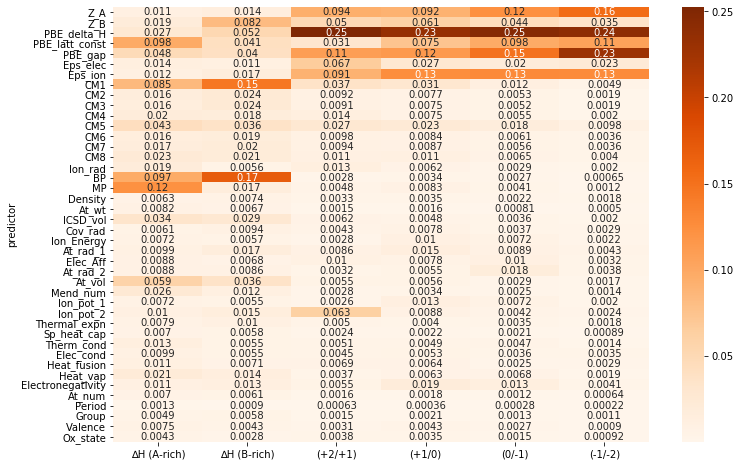

,output,train rmse,test rmse
0,∆H (A-rich),0.485138,1.253937
1,∆H (B-rich),0.557826,1.532842
2,(+2/+1),0.178044,0.540583
3,(+1/0),0.185052,0.527088
4,(0/-1),0.167055,0.455553
5,(-1/-2),0.157259,0.322435


In [135]:
RFR_optimized(df_nooutliers)

### Hyper parameter tuning with ``df_newcopy`` (low correlated descriptors removed and outliers removed)

---------
-------

# Hyperparameter tuning with ``GridSearchCV``

In [58]:
from sklearn.model_selection import GridSearchCV

In [72]:
def RFR_abbr_gridsearch(df):
    descriptors = df.columns[10:]
    output = df.columns[4:10]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    
    grid = {'max_depth': (4,5),
            'n_estimators': (500, 1000),
           'min_samples_split': (2,5,10),
            'min_samples_leaf': (2,4),
           'max_features':(3, 10, 25, None)}
    
    for o in output:
        clf_grid = GridSearchCV(estimator = RandomForestRegressor(),
                                param_grid = grid, cv=5, 
                                scoring='neg_root_mean_squared_error',
                                verbose=2, n_jobs=-1 )

        clf_grid.fit(train[descriptors], train[o])

        trainpred = clf_grid.best_estimator_.predict(train[descriptors])
        testpred = clf_grid.best_estimator_.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        
        print('{} best params: {}'.format(o, clf_grid.best_params_))
   
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)
    
    return rmse_df

In [73]:
RFR_abbr_gridsearch(df_nooutliers)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  6.2min finished


∆H (A-rich) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.7min finished


∆H (B-rich) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.8min finished


(+2/+1) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.6min finished


(+1/0) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.8min finished


(0/-1) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.9min finished


(-1/-2) best params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


,output,train rmse,test rmse
0,∆H (A-rich),1.183167,1.535322
1,∆H (B-rich),1.273187,1.786199
2,(+2/+1),0.510142,0.633077
3,(+1/0),0.540831,0.656963
4,(0/-1),0.464727,0.567114
5,(-1/-2),0.347946,0.405925


# RFR with hyperparameters:

- n_estimators = 1000
- max_depth = 5
- max_features = None
- min_samples_leaf = 2
- min_samples_split = 10

In [74]:
def RFR_optimized(df, o_start=4, o_end=10):
    '''
    o_start: int. column index of target value. (4 is the beginning)
    o_end: int. column index of target value. (10 is the end)
    '''
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_estimators=1000, max_features=None, max_depth=5,
                                min_samples_leaf=2, min_samples_split=10,
                                n_jobs=2, random_state=130)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    fig, axs = plt.subplots(1,6, figsize=(30,4))
    fig.subplots_adjust(wspace=0.2)
    
    for i, o in enumerate(output):
        clf.fit(train[descriptors], train[o])

        trainpred = clf.predict(train[descriptors])
        testpred = clf.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

        #parity plot 
        axs[i].scatter(train[o],trainpred, alpha = 0.5, label='train')
        axs[i].scatter(test[o],testpred, color='r', alpha = 0.5, label='test')
        axs[i].set_xlabel('train/test data')
        axs[i].set_ylabel('predicted train/test')
        axs[i].plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],lw=3,color='black')
        axs[i].set_title(o)
        axs[i].legend()
        #plt.show()

        descrip_importance = list(zip(train[descriptors], clf.feature_importances_))
        descr_df = pd.DataFrame(descrip_importance, columns =['predictor', o])
        frames_list.append(descr_df)
        #print(descr_df)
    
    print('Best params:', clf.get_params)
    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    result = pd.concat(frames_list, axis=1)
    result.drop(['predictor'], axis=1, inplace=True)
    result.insert(0, 'predictor', descriptors)
    
    result.set_index('predictor', inplace=True)
    
    plt.figure(figsize=(12,8))
    plt.title('Descriptor Importance in RFR model')
    sns.heatmap(result, annot=True, cmap='Oranges')
    plt.show()
    
    return rmse_df

Best params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


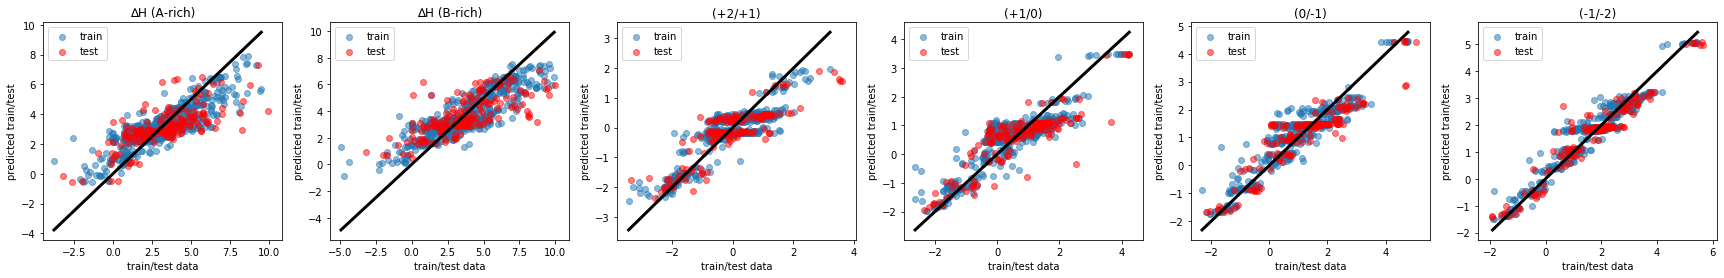

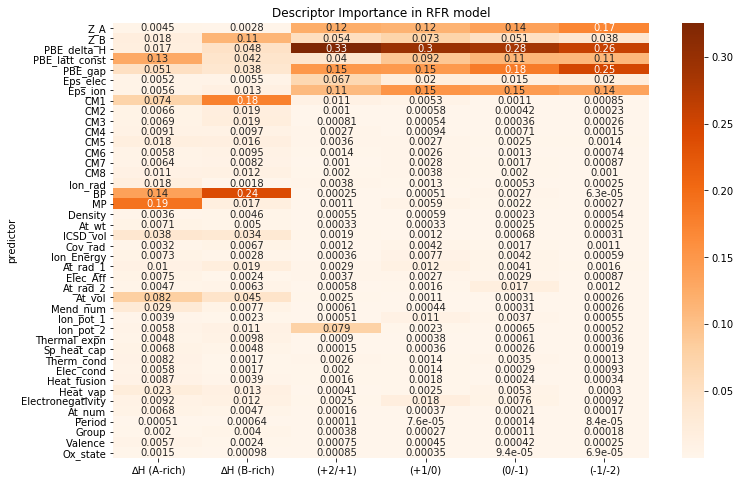

,output,train rmse,test rmse
0,∆H (A-rich),1.175892,1.538218
1,∆H (B-rich),1.295463,1.785922
2,(+2/+1),0.507433,0.633168
3,(+1/0),0.539572,0.656793
4,(0/-1),0.470556,0.565475
5,(-1/-2),0.354225,0.406049


In [76]:
RFR_optimized(df_nooutliers)

In [46]:
def RFR_abbr(df, o_start=4, o_end=10, test_size=0.22, num_trees=100,
             max_feat='auto', max_depth=None, min_samp_leaf=1, rs = 130):
    '''
    o_start: int. column index of target value. (4 is the beginning)
    o_end: int. column index of target value. (10 is the end)
    
    To reduce overfitting:
    - num_trees: more trees = less likely to overfit
    - max_feat: try reducing number
    - max_depth: lowering max depth
    - min_samp_leaf: values greater than 1
    '''
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=test_size, random_state=130)
    clf = RandomForestRegressor(n_estimators = num_trees, max_features=max_feat,
                                max_depth = max_depth, min_samples_leaf=1,
                                n_jobs=2, random_state=rs, oob_score=True)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    for o in output:
        clf.fit(train[descriptors], train[o])

        trainpred = clf.predict(train[descriptors])
        testpred = clf.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        
        print('train accuracy: ', clf.score(train[descriptors], train[o]))
        print('test accuracy: ', clf.score(test[descriptors], test[o]))
        print('oob: ', clf.oob_score_)

    print('Params:', clf.get_params)
    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    return rmse_df

In [47]:
RFR_abbr(df_nooutliers)

train accuracy:  0.947119251885906
test accuracy:  0.6714118501841039
oob:  0.5942129319069307
train accuracy:  0.9439104601075963
test accuracy:  0.6390233937250167
oob:  0.5839518238113279
train accuracy:  0.9701799981560242
test accuracy:  0.7931732928657008
oob:  0.7809639813998933
train accuracy:  0.9729842197009235
test accuracy:  0.8384671753283863
oob:  0.8000638802607425
train accuracy:  0.9805664832758852
test accuracy:  0.8865548420590037
oob:  0.8556126068480565
train accuracy:  0.9892663826419777
test accuracy:  0.949097578589019
oob:  0.9214912759396147
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                   

,output,train rmse,test rmse
0,∆H (A-rich),0.482355,1.259348
1,∆H (B-rich),0.567460,1.519628
2,(+2/+1),0.179011,0.533859
3,(+1/0),0.188701,0.513070
4,(0/-1),0.169284,0.461905
5,(-1/-2),0.129970,0.323699


In [48]:
RFR_abbr(df_nooutliers, test_size=0.1)

train accuracy:  0.9483200317526013
test accuracy:  0.5415188285966053
oob:  0.6358442049223458
train accuracy:  0.9468394623824552
test accuracy:  0.6361713670784881
oob:  0.6231731419287219
train accuracy:  0.971192552066319
test accuracy:  0.7455020985973121
oob:  0.7922965991760311
train accuracy:  0.9728549370124717
test accuracy:  0.8114961252777505
oob:  0.80320043914227
train accuracy:  0.9818437643509613
test accuracy:  0.8964677028616368
oob:  0.8677377919759207
train accuracy:  0.9903310676786338
test accuracy:  0.9614088321925977
oob:  0.9307312048819795
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                    

,output,train rmse,test rmse
0,∆H (A-rich),0.480692,1.472005
1,∆H (B-rich),0.557603,1.501855
2,(+2/+1),0.182242,0.516755
3,(+1/0),0.194891,0.493957
4,(0/-1),0.169139,0.390074
5,(-1/-2),0.127462,0.255009


In [49]:
RFR_abbr(df_nooutliers, max_depth = 4)

train accuracy:  0.6075195420206798
test accuracy:  0.4393568786067755
oob:  0.44203659557639574
train accuracy:  0.626410666177228
test accuracy:  0.4211871283256683
oob:  0.45212532754828927
train accuracy:  0.7196594158090405
test accuracy:  0.6810317554038099
oob:  0.6657671446339929
train accuracy:  0.7309655891041298
test accuracy:  0.7077483121703539
oob:  0.6788846574953549
train accuracy:  0.8009245649072387
test accuracy:  0.7991238644698386
oob:  0.7657073856061722
train accuracy:  0.891755544821342
test accuracy:  0.8973071834752753
oob:  0.8741610771968207
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                    

,output,train rmse,test rmse
0,∆H (A-rich),1.314095,1.644989
1,∆H (B-rich),1.464509,1.924273
2,(+2/+1),0.548869,0.662975
3,(+1/0),0.595484,0.690120
4,(0/-1),0.541812,0.614644
5,(-1/-2),0.412738,0.459772


In [50]:
RFR_abbr(df_nooutliers, max_depth = 4, num_trees=1000)

train accuracy:  0.6114382403897975
test accuracy:  0.451984395289786
oob:  0.4468748587655822
train accuracy:  0.6232107860728548
test accuracy:  0.4241524408189494
oob:  0.44672822765054765
train accuracy:  0.7175995715823553
test accuracy:  0.6717840484664201
oob:  0.6645810603134303
train accuracy:  0.7336925037747479
test accuracy:  0.7031812455518147
oob:  0.6844208332463888
train accuracy:  0.8032992697230077
test accuracy:  0.7946367974226842
oob:  0.7739017583141865
train accuracy:  0.8907469811158012
test accuracy:  0.8952435674037751
oob:  0.8731100342294279
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                    

,output,train rmse,test rmse
0,∆H (A-rich),1.307518,1.626359
1,∆H (B-rich),1.470767,1.919338
2,(+2/+1),0.550882,0.672517
3,(+1/0),0.592458,0.695492
4,(0/-1),0.538571,0.621471
5,(-1/-2),0.414656,0.464369


In [190]:
RFR_abbr(df_nooutliers, max_feat=3)

train accuracy:  0.9358073183839196
test accuracy:  0.5909651354503984
oob:  0.5224676747220023
train accuracy:  0.9356797428959153
test accuracy:  0.569363076624338
oob:  0.522888151023073
train accuracy:  0.9372949114940654
test accuracy:  0.5811606716097764
oob:  0.5407516221754854
train accuracy:  0.9473696983174075
test accuracy:  0.6647858696542792
oob:  0.6146601132458853
train accuracy:  0.9593724130462024
test accuracy:  0.6959086294263512
oob:  0.6986974595944055
train accuracy:  0.9685683758270364
test accuracy:  0.7696492065504779
oob:  0.7702118854852411
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_

,output,train rmse,test rmse
0,∆H (A-rich),0.531447,1.405077
1,∆H (B-rich),0.607671,1.659790
2,(+2/+1),0.259584,0.759709
3,(+1/0),0.263381,0.739107
4,(0/-1),0.244766,0.756244
5,(-1/-2),0.222410,0.688601


In [192]:
RFR_abbr(df_nooutliers, max_feat='sqrt')

train accuracy:  0.939080800522043
test accuracy:  0.6315801894723192
oob:  0.5432229966665334
train accuracy:  0.9383598183523502
test accuracy:  0.59990249821066
oob:  0.5443886356278745
train accuracy:  0.9570893261113598
test accuracy:  0.7039919591053106
oob:  0.6875932165617633
train accuracy:  0.9639739334575931
test accuracy:  0.7864621314081237
oob:  0.7319768694497046
train accuracy:  0.9772046255239439
test accuracy:  0.8276405363083417
oob:  0.8296528911384694
train accuracy:  0.9854364772140978
test accuracy:  0.9029113567792073
oob:  0.8924075077116684
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                    

,output,train rmse,test rmse
0,∆H (A-rich),0.517720,1.333495
1,∆H (B-rich),0.594876,1.599855
2,(+2/+1),0.214738,0.638668
3,(+1/0),0.217909,0.589907
4,(0/-1),0.183343,0.569347
5,(-1/-2),0.151393,0.447051


In [172]:
RFR_abbr(df_nooutliers, max_depth=10)

Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


,output,train rmse,test rmse
0,∆H (A-rich),0.608331,1.299554
1,∆H (B-rich),0.706901,1.551873
2,(+2/+1),0.265456,0.549590
3,(+1/0),0.283478,0.535120
4,(0/-1),0.247318,0.478708
5,(-1/-2),0.179733,0.332264


In [53]:
RFR_abbr(df_nooutliers, num_trees=1000, min_samp_leaf=5, max_depth=10)

train accuracy:  0.9165505154219028
test accuracy:  0.6519275564495958
oob:  0.5955024034328649
train accuracy:  0.9153854247751363
test accuracy:  0.6224095785552577
oob:  0.5856784692797986
train accuracy:  0.9329198303092796
test accuracy:  0.7810265282989485
oob:  0.7721888023248098
train accuracy:  0.9384941798571701
test accuracy:  0.8166414530585667
oob:  0.792665285010179
train accuracy:  0.9596605573260975
test accuracy:  0.8795564287831389
oob:  0.8555987948876003
train accuracy:  0.9797247385820214
test accuracy:  0.9476627631353788
oob:  0.9204326213407317
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                    

,output,train rmse,test rmse
0,∆H (A-rich),0.605940,1.296148
1,∆H (B-rich),0.696975,1.554204
2,(+2/+1),0.268487,0.549312
3,(+1/0),0.284724,0.546634
4,(0/-1),0.243896,0.475939
5,(-1/-2),0.178630,0.328230


In [54]:
RFR_abbr(df_nooutliers, num_trees=1000, min_samp_leaf=5, max_depth=8)

train accuracy:  0.8683979196392175
test accuracy:  0.6189208828278872
oob:  0.5760145429100656
train accuracy:  0.87472069239857
test accuracy:  0.6013446693013806
oob:  0.5755162926338142
train accuracy:  0.8884909499535955
test accuracy:  0.7686439008606976
oob:  0.75473249268233
train accuracy:  0.8965360307990529
test accuracy:  0.7992708199941067
oob:  0.7722327171305756
train accuracy:  0.9333242765146417
test accuracy:  0.8700500886592715
oob:  0.8469246335599974
train accuracy:  0.9680525036341766
test accuracy:  0.9426040133595159
oob:  0.9177912521982886
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_

,output,train rmse,test rmse
0,∆H (A-rich),0.760937,1.356211
1,∆H (B-rich),0.848075,1.596969
2,(+2/+1),0.346163,0.564630
3,(+1/0),0.369284,0.571941
4,(0/-1),0.313562,0.494365
5,(-1/-2),0.224228,0.343727


In [55]:
RFR_abbr(df_nooutliers, num_trees=1000, min_samp_leaf=5, max_depth=5)

train accuracy:  0.7024589373557473
test accuracy:  0.5141132518875879
oob:  0.4983864050041408
train accuracy:  0.7252469786845139
test accuracy:  0.5088024014796556
oob:  0.5064612850465109
train accuracy:  0.7709891041068831
test accuracy:  0.7127877596470682
oob:  0.6961166063154125
train accuracy:  0.7890739224957386
test accuracy:  0.7375337858717919
oob:  0.7168212175759675
train accuracy:  0.855109726470165
test accuracy:  0.8297622604012796
oob:  0.8097298307133696
train accuracy:  0.9245835402427098
test accuracy:  0.917712483118165
oob:  0.8994629485011711
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      

,output,train rmse,test rmse
0,∆H (A-rich),1.144171,1.531395
1,∆H (B-rich),1.255931,1.772661
2,(+2/+1),0.496083,0.629108
3,(+1/0),0.527268,0.654008
4,(0/-1),0.462232,0.565832
5,(-1/-2),0.344512,0.411566


In [174]:
RFR_abbr(df_nooutliers, num_trees=35, min_samp_leaf=5, max_depth=10)

Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=35, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


,output,train rmse,test rmse
0,∆H (A-rich),0.625048,1.274812
1,∆H (B-rich),0.741217,1.550264
2,(+2/+1),0.272663,0.563464
3,(+1/0),0.278977,0.542639
4,(0/-1),0.250377,0.479747
5,(-1/-2),0.181383,0.335294


In [175]:
RFR_abbr(df_nooutliers, max_feat=10, num_trees=1000, min_samp_leaf=5, max_depth=10)

Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


,output,train rmse,test rmse
0,∆H (A-rich),0.629572,1.343976
1,∆H (B-rich),0.728492,1.578572
2,(+2/+1),0.311774,0.588201
3,(+1/0),0.315646,0.570948
4,(0/-1),0.266622,0.519991
5,(-1/-2),0.199936,0.383060


In [177]:
RFR_abbr(df_nooutliers, max_feat=None, min_samp_leaf=5, max_depth=10)

Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=2, oob_score=False,
                      random_state=130, verbose=0, warm_start=False)>


,output,train rmse,test rmse
0,∆H (A-rich),0.608331,1.299554
1,∆H (B-rich),0.706901,1.551873
2,(+2/+1),0.265456,0.549590
3,(+1/0),0.283478,0.535120
4,(0/-1),0.247318,0.478708
5,(-1/-2),0.179733,0.332264


In [59]:
RFR_abbr(df_nooutliers, max_feat='sqrt', min_samp_leaf=5, max_depth=10)

train accuracy:  0.8951675749603895
test accuracy:  0.5995835565952554
oob:  0.5421017845153742
train accuracy:  0.9005721647876969
test accuracy:  0.5895655533245966
oob:  0.5456824922449495
train accuracy:  0.893456052919034
test accuracy:  0.6764605123408489
oob:  0.6597364889111559
train accuracy:  0.9152506953349847
test accuracy:  0.770870503176696
oob:  0.7267406588750858
train accuracy:  0.9407339682287702
test accuracy:  0.8142518095304441
oob:  0.8168705971080519
train accuracy:  0.9689063845398762
test accuracy:  0.9010587468083524
oob:  0.8850744127492289
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                     

,output,train rmse,test rmse
0,∆H (A-rich),0.679150,1.390195
1,∆H (B-rich),0.755525,1.620390
2,(+2/+1),0.338369,0.667709
3,(+1/0),0.334221,0.611064
4,(0/-1),0.295626,0.591047
5,(-1/-2),0.221211,0.451296


In [57]:
RFR_abbr(df_nooutliers, max_feat='sqrt', num_trees=1000, min_samp_leaf=5, max_depth=5)

train accuracy:  0.6562246634104376
test accuracy:  0.4918741053954429
oob:  0.47918883778464005
train accuracy:  0.6543806780442846
test accuracy:  0.45733847887489676
oob:  0.4442243051214815
train accuracy:  0.6800763671073234
test accuracy:  0.5643374282103053
oob:  0.5655477691459022
train accuracy:  0.7197955165364621
test accuracy:  0.6491887704454224
oob:  0.6205198550757238
train accuracy:  0.795717117320704
test accuracy:  0.704913575720918
oob:  0.7239808494816167
train accuracy:  0.857118826653158
test accuracy:  0.8006884137936255
oob:  0.7971620908486858
Params: <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                     

,output,train rmse,test rmse
0,∆H (A-rich),1.229858,1.566050
1,∆H (B-rich),1.408619,1.863211
2,(+2/+1),0.586340,0.774816
3,(+1/0),0.607720,0.756107
4,(0/-1),0.548853,0.744962
5,(-1/-2),0.474197,0.640529


----
----

# Functions

In [7]:
def counter(dataframe, column):
    '''
    This function counts the number of each unique variable for a given
    column of data.

    Inputs
        - dataframe: pd df. Dataframe containing information you would like
        to enumerate
        - column: string. Name of the column you like to enumerate.

    Outputs
        - count df: pd df. Dataframe with the name of each unique value,
        how many times it occurs, and percentage of total.
    '''

    count = pd.value_counts(dataframe[column])
    count_df = count.to_frame()
    count_df['percent']=round(count_df[column]/sum(count)*100,2)

    print('Total entries: ', sum(count))

    return count_df

# Old funcs

In [ ]:
def RFR_abbr(df, o_start=4, o_end=10):
    '''
    o_start: int. column index of target value. (4 is the beginning)
    o_end: int. column index of target value. (10 is the end)
    '''
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_jobs=2, random_state=130)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    for o in output:
        clf.fit(train[descriptors], train[o])

        trainpred = clf.predict(train[descriptors])
        testpred = clf.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    return rmse_df

In [ ]:
def type_counter(dataframe):
    type_list = list(dataframe.Type)

    two_six = []
    three_five = []
    four_four = []

    for typ in type_list:
        if typ == 'IV-IV':
            four_four.append(typ)
        elif typ == 'II-VI':
            two_six.append(typ)
        elif typ == 'III-V':
            three_five.append(typ)
        else:
            pass

    total = len(two_six)+len(three_five)+len(four_four)


    print('Total entries: ', total)
    print('II-VI: {}, {}%'.format(len(two_six), round((len(two_six)/total*100),2)))
    print('III-V: {}, {}%'.format(len(three_five), round((len(three_five)/total*100),2)))
    print('IV-IV: {}, {}%'.format(len(four_four), round((len(four_four)/total*100),2)))
    
    return

In [125]:
def RFR_individual_opt(dataframe, column, n_est=100, min_samp_split=2, min_samp_leaf=1, max_depth=None):
    '''
    column is integer that corresponds to index in output list, ie 0 = dH-A, 1 = dH-B
    '''
    descriptors = dataframe.columns[10:]
    output = dataframe.columns[4:10] 
    o = output[column]
    train,test = train_test_split(dataframe,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_estimators=n_est, min_samples_split=min_samp_split, min_samples_leaf=min_samp_leaf,
                                max_depth=max_depth, n_jobs=2, random_state=130)
    
    
    clf.fit(train[descriptors], train[o])

    trainpred = clf.predict(train[descriptors])
    testpred = clf.predict(test[descriptors])
        
    train_rmse = mean_squared_error(train[o],trainpred, squared=False)
    test_rmse = mean_squared_error(test[o],testpred, squared=False)
     
    plt.figure(figsize=(4,4))
    plt.scatter(train[o],trainpred, label='train')
    plt.scatter(test[o],testpred,color='r', label='test')
    plt.xlabel('train/test data')
    plt.ylabel('predicted train/test')
    plt.plot([train[o].min(),train[o].max()],[trainpred.min(),trainpred.max()],lw=4,color='black')
    plt.title(o)
    plt.legend()
    plt.show()

    print("Train RMSE", train_rmse)
    print("Test RMSE", test_rmse)
    return

In [ ]:
def RFR_type_plot(df, o_start=4, o_end=10):
    
    descriptors = df.columns[10:]
    output = df.columns[4:10]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_jobs=2, random_state=130)
    
    
    for o in output:
        clf.fit(train[descriptors], train[o])
        
        alltrainpred = clf.predict(train[descriptors])
        #alltestpred = clf.predict(test[descriptors])
        
        groups = test.groupby('Type')
        
        fig, ax = plt.subplots(figsize=(4,4))
        ax.scatter(train[o],alltrainpred, label='train', color='gray')
        for (name, group) in groups:
            ax.scatter(group[o], clf.predict(group[descriptors]), label=name)
        ax.set_xlabel('train/test data')
        ax.set_ylabel('predicted train/test')
        #ax.plot([train[o].min(),train[o].max()],[alltrainpred.min(),alltrainpred.max()],lw=4,color='black')
        ax.plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],lw=4,color='black')
        ax.set_title(o)
        ax.legend()

    return

In [138]:
def RFR_old(df, o_start=4, o_end=10):
    '''
    o_start: int. column index of target value. (4 is the beginning)
    o_end: int. column index of target value. (10 is the end)
    '''
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_jobs=2, random_state=130)
    
    frames_list = []
    train_rmse_list = [] 
    test_rmse_list = []
    
    for o in output:
        clf.fit(train[descriptors], train[o])

        trainpred = clf.predict(train[descriptors])
        testpred = clf.predict(test[descriptors])
        
        train_rmse = mean_squared_error(train[o],trainpred, squared=False)
        test_rmse = mean_squared_error(test[o],testpred, squared=False)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)

        #parity plot 
        plt.figure(figsize=(4,4))
        plt.scatter(train[o],trainpred, alpha = 0.5, label='train')
        plt.scatter(test[o],testpred, color='r', alpha = 0.5, label='test')
        plt.xlabel('train/test data')
        plt.ylabel('predicted train/test')
        plt.plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],lw=3,color='black')
        plt.title(o)
        plt.legend()
        plt.show()

        #print("Train RMSE", train_rmse)
        #print("Test RMSE", test_rmse)

        descrip_importance = list(zip(train[descriptors], clf.feature_importances_))
        descr_df = pd.DataFrame(descrip_importance, columns =['predictor', o])
        frames_list.append(descr_df)
        #print(descr_df)
    
    print('Best params:', clf.get_params)
    
    d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}
    
    rmse_df = pd.DataFrame(data=d)

    result = pd.concat(frames_list, axis=1)
    result.drop(['predictor'], axis=1, inplace=True)
    result.insert(0, 'predictor', descriptors)
    
    result.set_index('predictor', inplace=True)
    
    plt.figure(figsize=(12,8))
    plt.title('Descriptor Importance in RFR model')
    sns.heatmap(result, annot=True, cmap='Oranges')
    plt.show()
    
    return rmse_df

In [ ]:
def RFR_type_old(df, o_start=4, o_end=10):
    
    descriptors = df.columns[10:]
    output = df.columns[o_start:o_end]
    train,test = train_test_split(df,test_size=0.22, random_state=130)
    clf = RandomForestRegressor(n_jobs=2, random_state=130)
    
    train_26 = train[train['Type']=='II-VI']
    train_35 = train[train['Type']=='III-V']
    train_44 =  train[train['Type']=='IV-IV']

    test_26 = test[test['Type']=='II-VI']
    test_35 = test[test['Type']=='III-V']
    test_44 = test[test['Type']=='IV-IV']
    
    traintest_list = [(train_26, test_26),(train_35, test_35),(train_44, test_44)]
    
    tt_dict = {}
    
    for tt in traintest_list:
        
        key = str(tt[0].Type.unique())
        
        train_rmse_list = [] 
        test_rmse_list = []
        
        for o in output:
            clf.fit(train[descriptors], train[o])

            trainpred = clf.predict(tt[0][descriptors])
            testpred = clf.predict(tt[1][descriptors])

            train_rmse = mean_squared_error(tt[0][o],trainpred, squared=False)
            test_rmse = mean_squared_error(tt[1][o],testpred, squared=False)

            
            train_rmse_list.append(train_rmse)
            test_rmse_list.append(test_rmse)
        
        #print('train', train_rmse_list)
        #print('test', test_rmse_list)
            
        d = {'output': output, 'train rmse': train_rmse_list, 'test rmse': test_rmse_list}

        rmse_df = pd.DataFrame(data=d)
        
        tt_dict[key] = (rmse_df)
        
    for o in output:
        clf.fit(train[descriptors], train[o])
        
        alltrainpred = clf.predict(train[descriptors])
        #alltestpred = clf.predict(test[descriptors])
        
        groups = test.groupby('Type')
        
        fig, ax = plt.subplots(figsize=(4,4))
        ax.scatter(train[o],alltrainpred, label='train', alpha=0.5, color='gray')
        for (name, group) in groups:
            ax.scatter(group[o], clf.predict(group[descriptors]), alpha=0.7, label=name)
        ax.set_xlabel('train/test data')
        ax.set_ylabel('predicted train/test')
        #ax.plot([train[o].min(),train[o].max()],[alltrainpred.min(),alltrainpred.max()],lw=4,color='black')
        ax.plot([train[o].min(),train[o].max()],[train[o].min(),train[o].max()],lw=3,color='black')
        ax.set_title(o)
        ax.legend()
    
    return tt_dict